<a href="https://colab.research.google.com/github/sarcasticvibes/Face-Mask-Detection-via-Detectron2/blob/master/Face_Mask_Detection_via_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarcasticvibes","key":"41883d4fbccff1f3662a136f9c271ee4"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d wobotintelligence/face-mask-detection-dataset

 99% 2.49G/2.50G [00:36<00:00, 45.4MB/s]
100% 2.50G/2.50G [00:36<00:00, 73.3MB/s]


In [0]:
! unzip face-mask-detection-dataset.zip

In [6]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 4.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=426230d5596cf370376759db3abc0fafaafe2b8e3244a1adb04b40742700e235
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-vi7_69f7
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-vi7_69f7
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [7]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 1.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200613-cp36-none-any.whl size=41028 sha256=acde04f88592fc9c7db127a7746297c0abf5bc1f417552c91dccadf8c3803886
  Stored in directory: /root/.cache/pip/wheels/bf/54/92/c61c94b4b7c491dec867d287a75ef6fa0a536ab64920e8b778
Successfully built fvcore


In [9]:
import torch
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [0]:
import os
import pandas as pd
import torch.nn as nn
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
import random
import cv2
from google.colab.patches import cv2_imshow

In [0]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [0]:
df = pd.read_csv('/content/train.csv')

In [11]:
df

name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
2      2756.png   75  252  264  390   mask_colorful
3      2756.png  521  136  711  277   mask_colorful
4      6098.jpg  360   85  728  653    face_no_mask
...         ...  ...  ...  ...  ...             ...
15407  1894.jpg  437  121  907  644  face_with_mask
15408  1894.jpg  557  363  876  636   mask_surgical
15409  1894.jpg  411    3  940  325             hat
15410  3216.png  126   69  409  463  face_with_mask
15411  3216.png  136  289  393  461   mask_colorful

[15412 rows x 6 columns]

In [0]:
img_folder_dir = '/content/Medical mask/Medical mask/Medical Mask/images'

In [0]:
! mkdir /content/image_pickles

In [20]:
import joblib
for image in tqdm(os.listdir(img_folder_dir), total=len(os.listdir(img_folder_dir))):
  im = np.array(Image.open(f'{img_folder_dir}/{image}'))
  image_id = image[:-4] if '.jpeg' not in image else image[:-5]
  assert int(image_id)
  joblib.dump(im, f"/content/image_pickles/{image_id}.pkl")

In [0]:
categories = {j:i for i, j in enumerate(df.classname.unique())}

In [14]:
categories

{'balaclava_ski_mask': 18,
 'eyeglasses': 7,
 'face_no_mask': 2,
 'face_other_covering': 5,
 'face_shield': 9,
 'face_with_mask': 0,
 'face_with_mask_incorrect': 3,
 'gas_mask': 17,
 'goggles': 13,
 'hair_net': 14,
 'hat': 12,
 'helmet': 8,
 'hijab_niqab': 15,
 'hood': 11,
 'mask_colorful': 1,
 'mask_surgical': 4,
 'other': 16,
 'scarf_bandana': 6,
 'sunglasses': 10,
 'turban': 19}

In [0]:
def get_train_dataset():
  train_data = []
  for img in df.name.unique():
    record = {}
    image_id = img[:-4] if '.jpeg' not in img else img[:-5]
    height, width, _ = np.array(Image.open(f'{img_folder_dir}/{img}')).shape
    record['file_name'] = f'{img_folder_dir}/{img}'
    record["image_id"] = image_id
    record["height"] = height
    record["width"] = width

    objs = []
    d = df[df['name'] == img]
    x1, x2, y1, y2, labels = d.x1.values, d.x2.values, d.y1.values, d.y2.values, d.classname.values
    annos = [(x1_, y1_, x2_, y2_) for x1_ ,y1_, x2_, y2_ in zip(x1, y1, x2, y2)]
    polys = [[(x1_, y1_), (x1_, y2_), (x2_, y1_), (x2_, y2_)] for x1_ ,y1_, x2_, y2_ in zip(x1, y1, x2, y2)]
    for anno, poly, label in zip(annos, polys, labels):
      obj = {
              "bbox": anno,
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": categories[label],
              "iscrowd": 0
          }
      objs.append(obj)
    record["annotations"] = objs
    train_data.append(record)
  return train_data

In [0]:
def get_test_dataset():
  d = pd.read_csv('/content/Submission_images.csv')
  test_data = []
  for img in d.name.unique():
    record = {}
    image_id = img[:-4] if '.jpeg' not in img else img[:-5]
    if ('jpe' in img and 'jpeg' not in img):
      img = (img + 'g') 
    height, width, _ = np.array(Image.open(f'{img_folder_dir}/{img}')).shape
    record['file_name'] = f'{img_folder_dir}/{img}'
    record["image_id"] = image_id
    record["height"] = height
    record["width"] = width
    record["annotations"] = None
    test_data.append(record)
  return test_data

In [0]:
get_train_dataset()

In [0]:
d="train"
DatasetCatalog.register("Face_Mask_Detection_TrainingSet", lambda d=d: get_train_dataset())
MetadataCatalog.get("Face_Mask_Detection_TrainingSet").set(thing_classes=[class_ for class_ in df.classname.unique()])
text_metadata = MetadataCatalog.get("Face_Mask_Detection_TrainingSet")

In [0]:
d="test"
DatasetCatalog.register("Face_Mask_Detection_TestSet", lambda d=d: get_test_dataset())
MetadataCatalog.get("Face_Mask_Detection_TestSet").set(thing_classes=[class_ for class_ in df.classname.unique()])
text_metadata = MetadataCatalog.get("Face_Mask_Detection_TestSet")

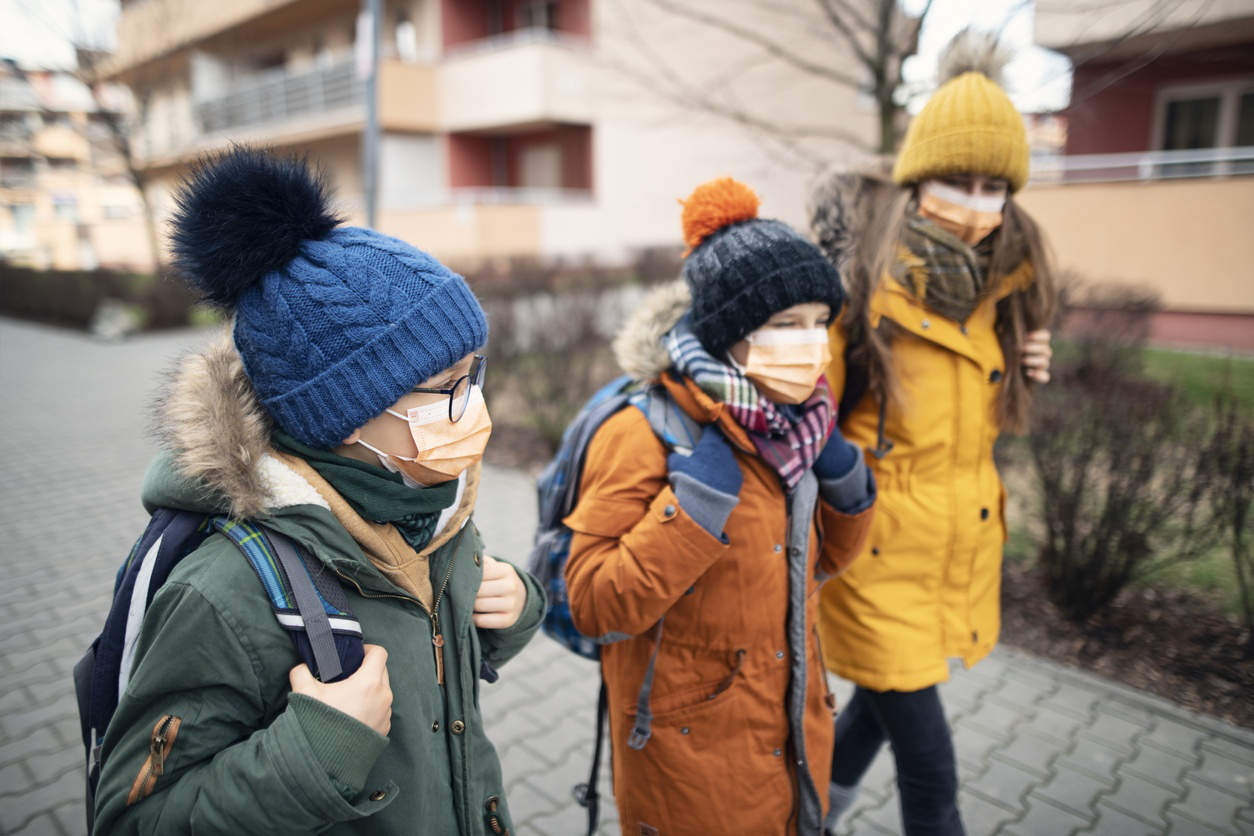

In [21]:
Image.open(f'{img_folder_dir}/1799.jpg')

In [39]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Face_Mask_Detection_TrainingSet",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  
cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.0002  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20  # only has one class (text)
cfg.OUTPUT_DIR = f'/content/drive/My Drive/Face_Mask_Detection_via_Detectron2outputs/'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/13 20:36:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (21, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (21,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (80, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (80,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (20, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (20,) in the model!


[06/13 20:37:58 d2.engine.train_loop]: Starting training from iteration 0
[06/13 20:38:34 d2.utils.events]:  eta: 4:40:06  iter: 19  total_loss: 5.183  loss_cls: 3.153  loss_box_reg: 0.086  loss_mask: 0.694  loss_rpn_cls: 1.048  loss_rpn_loc: 0.183  time: 1.7315  data_time: 0.3809  lr: 0.000004  max_mem: 11685M
[06/13 20:39:07 d2.utils.events]:  eta: 4:36:06  iter: 39  total_loss: 4.839  loss_cls: 3.018  loss_box_reg: 0.083  loss_mask: 0.693  loss_rpn_cls: 0.886  loss_rpn_loc: 0.134  time: 1.7120  data_time: 0.3860  lr: 0.000008  max_mem: 11685M
[06/13 20:39:42 d2.utils.events]:  eta: 4:36:33  iter: 59  total_loss: 4.312  loss_cls: 2.732  loss_box_reg: 0.076  loss_mask: 0.693  loss_rpn_cls: 0.772  loss_rpn_loc: 0.165  time: 1.7102  data_time: 0.3530  lr: 0.000012  max_mem: 11685M
[06/13 20:40:15 d2.utils.events]:  eta: 4:34:10  iter: 79  total_loss: 3.811  loss_cls: 2.324  loss_box_reg: 0.083  loss_mask: 0.693  loss_rpn_cls: 0.597  loss_rpn_loc: 0.103  time: 1.7013  data_time: 0.3258  

In [44]:
# Look at training curves in tensorboard:
! kill 5487
%load_ext tensorboard
%tensorboard --logdir content/drive/My Drive/Face_Mask_Detection_via_Detectron2outputs/events.out.tfevents.1592080678.1e504b5410bf.121.2

/bin/bash: line 0: kill: (5487) - No such process
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-06-14 01:32:46.646358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT]
                   {se

In [0]:
cfg.MODEL.WEIGHTS = '/content/drive/My Drive/Face_Mask_Detection_via_Detectron2outputs/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Face_Mask_Detection_TestSet", )
predictor = DefaultPredictor(cfg)

In [0]:
train_dataset_dicts = get_train_dataset()

In [0]:
test_dataset_dicts = get_test_dataset()

{'instances': Instances(num_instances=1, image_height=2282, image_width=4231, fields=[pred_boxes: Boxes(tensor([[2717.3276, 1584.6345, 4096.7236, 2282.0000]], device='cuda:0')), scores: tensor([0.4513], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


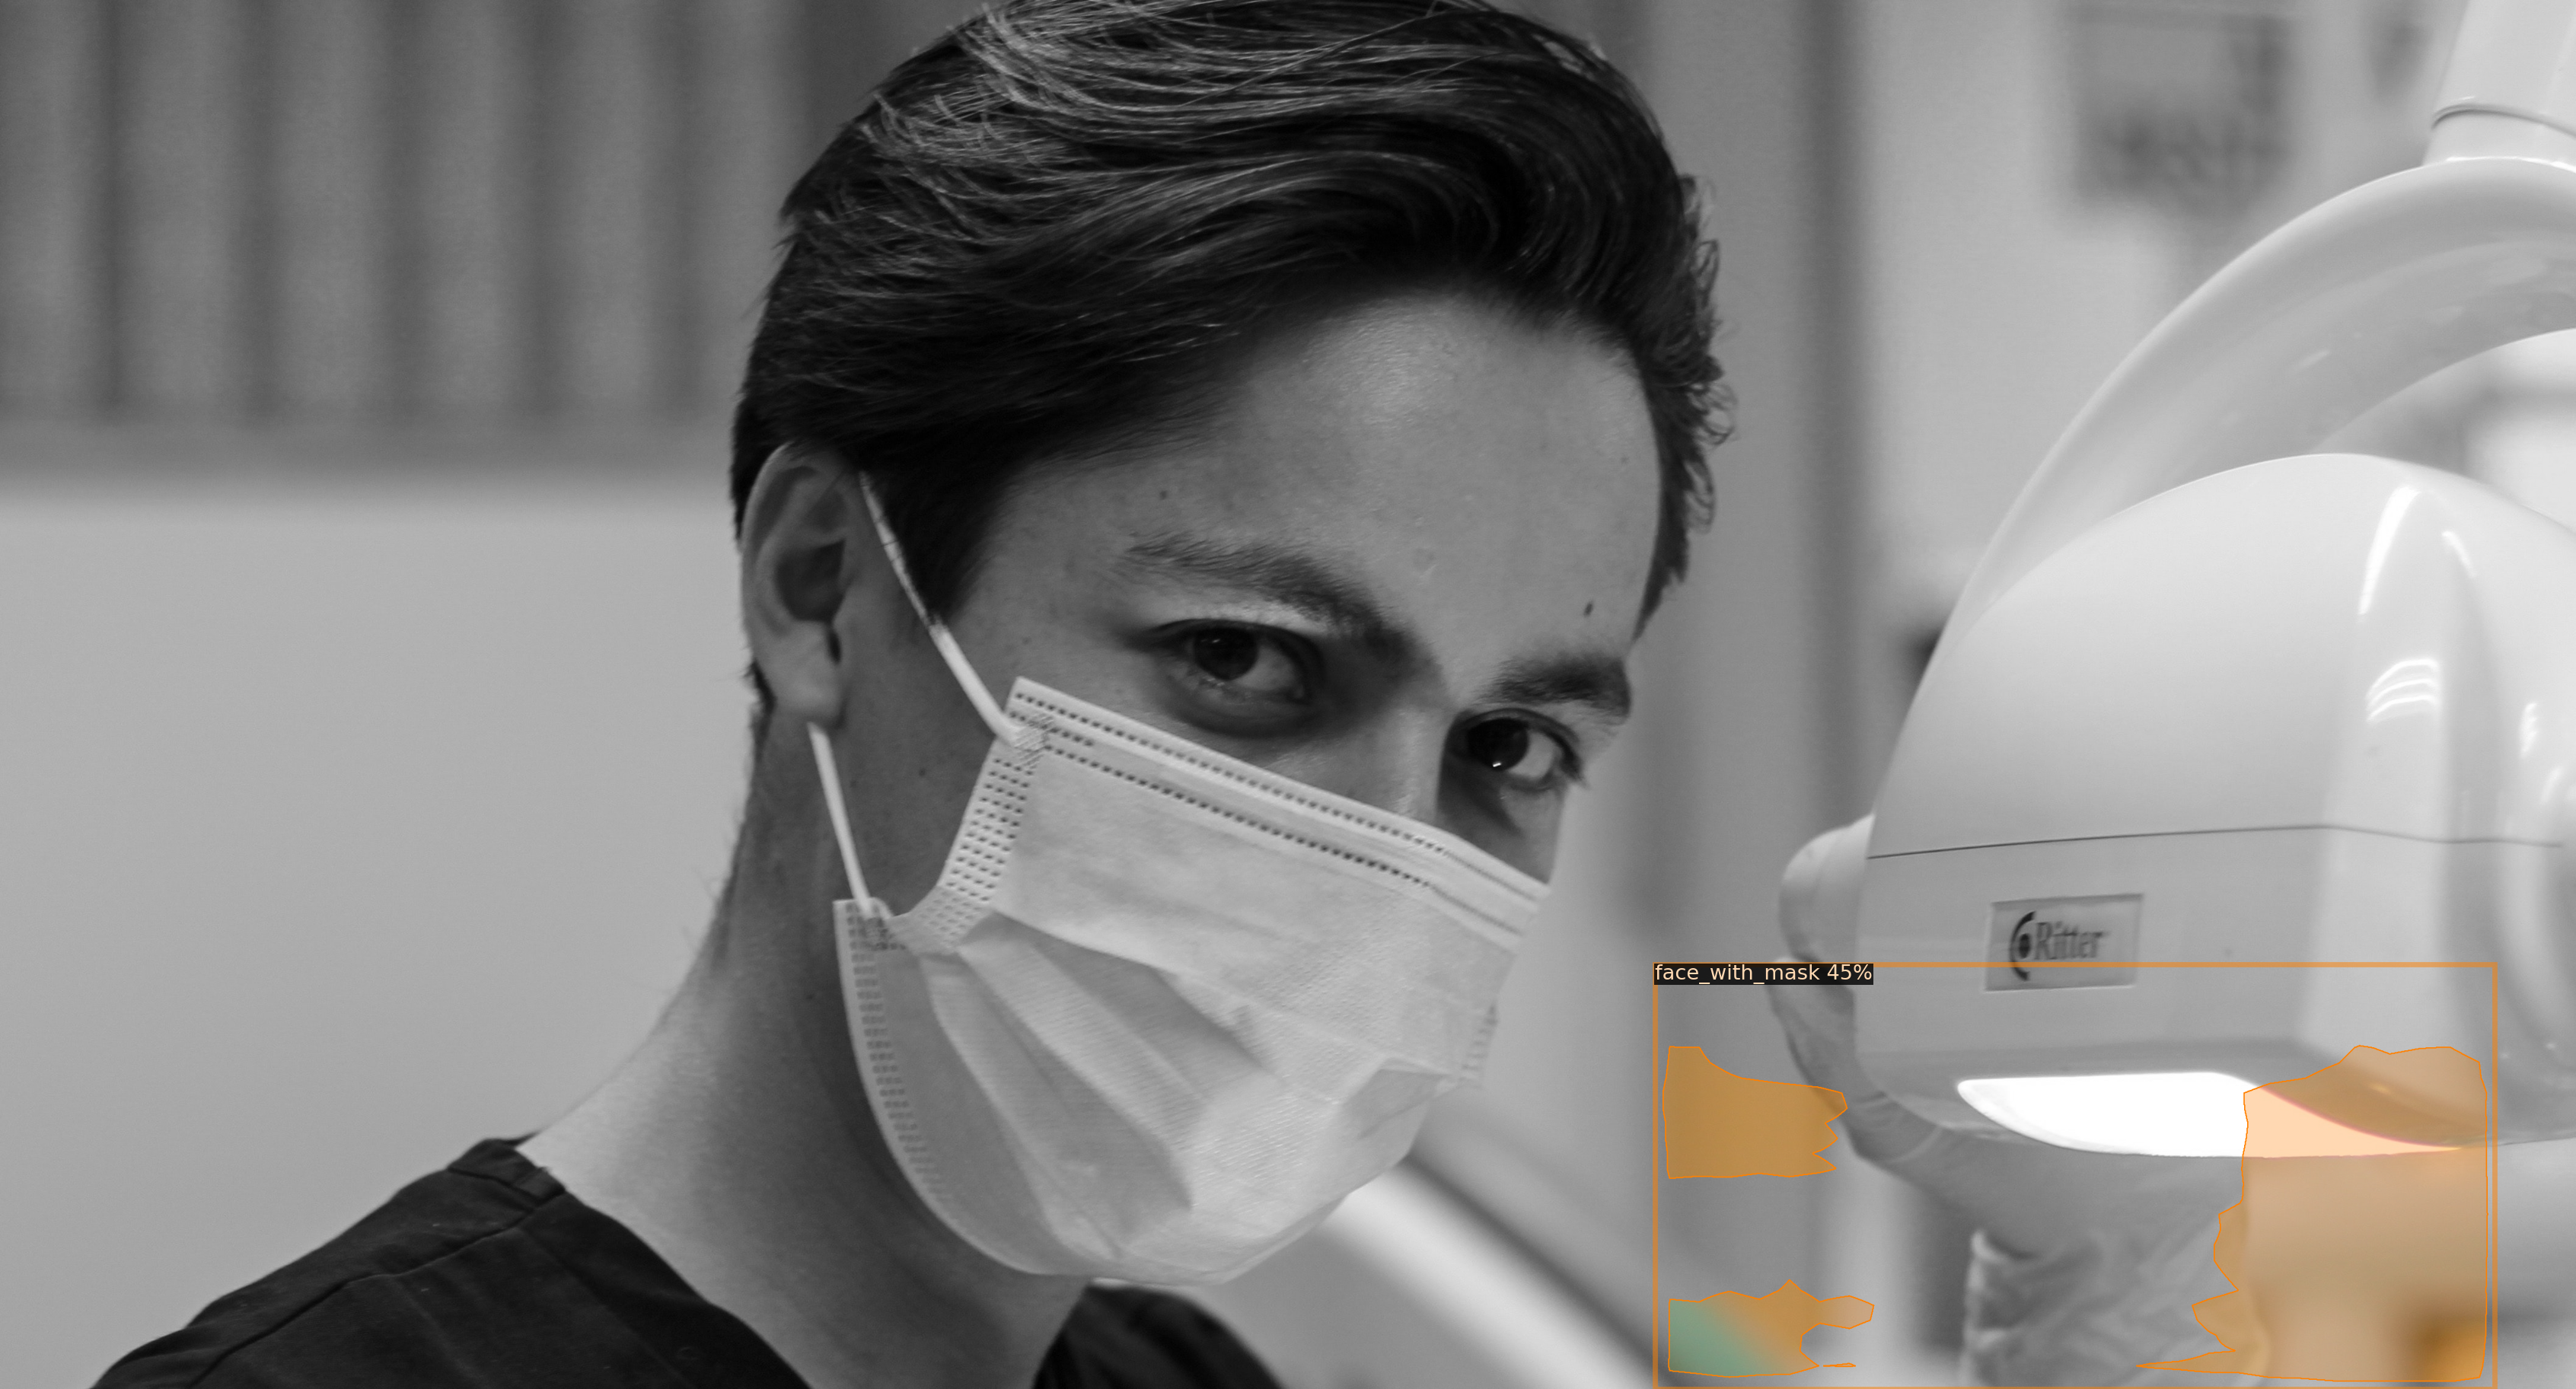

{'instances': Instances(num_instances=3, image_height=975, image_width=1100, fields=[pred_boxes: Boxes(tensor([[176.9899, 460.5773, 989.8297, 955.2363],
        [ 99.9207, 481.0511, 683.0616, 904.5012],
        [224.6754, 453.0112, 844.7117, 958.2674]], device='cuda:0')), scores: tensor([0.4524, 0.2895, 0.2694], device='cuda:0'), pred_classes: tensor([0, 0, 4], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, F

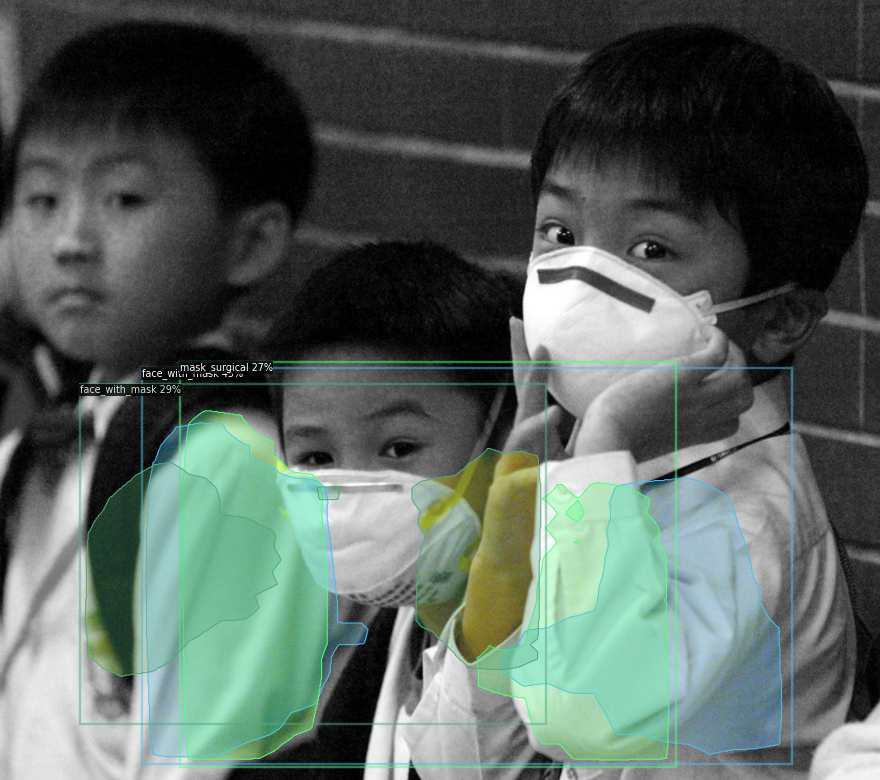

{'instances': Instances(num_instances=10, image_height=999, image_width=1500, fields=[pred_boxes: Boxes(tensor([[ 808.6356,  410.3559, 1449.3805,  940.4250],
        [ 848.9660,  404.5324, 1351.9666,  689.3749],
        [  26.5751,  363.7075,  274.8939,  590.8643],
        [ 404.8045,  474.4811, 1354.4740,  994.5100],
        [  38.1633,  382.8748,  564.4200,  901.0995],
        [ 113.2378,  410.3062,  955.3804,  995.0747],
        [ 804.6135,  438.5878, 1201.9152,  851.2117],
        [ 433.2920,  419.9276, 1161.8276,  995.5547],
        [ 277.6565,  327.7481, 1171.5385,  991.4775],
        [ 243.2438,  470.5379,  614.8709,  855.3032]], device='cuda:0')), scores: tensor([0.4352, 0.3632, 0.3016, 0.2978, 0.2951, 0.2814, 0.2475, 0.2066, 0.2057,
        0.2015], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0, 4, 4, 7, 4], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [Fa

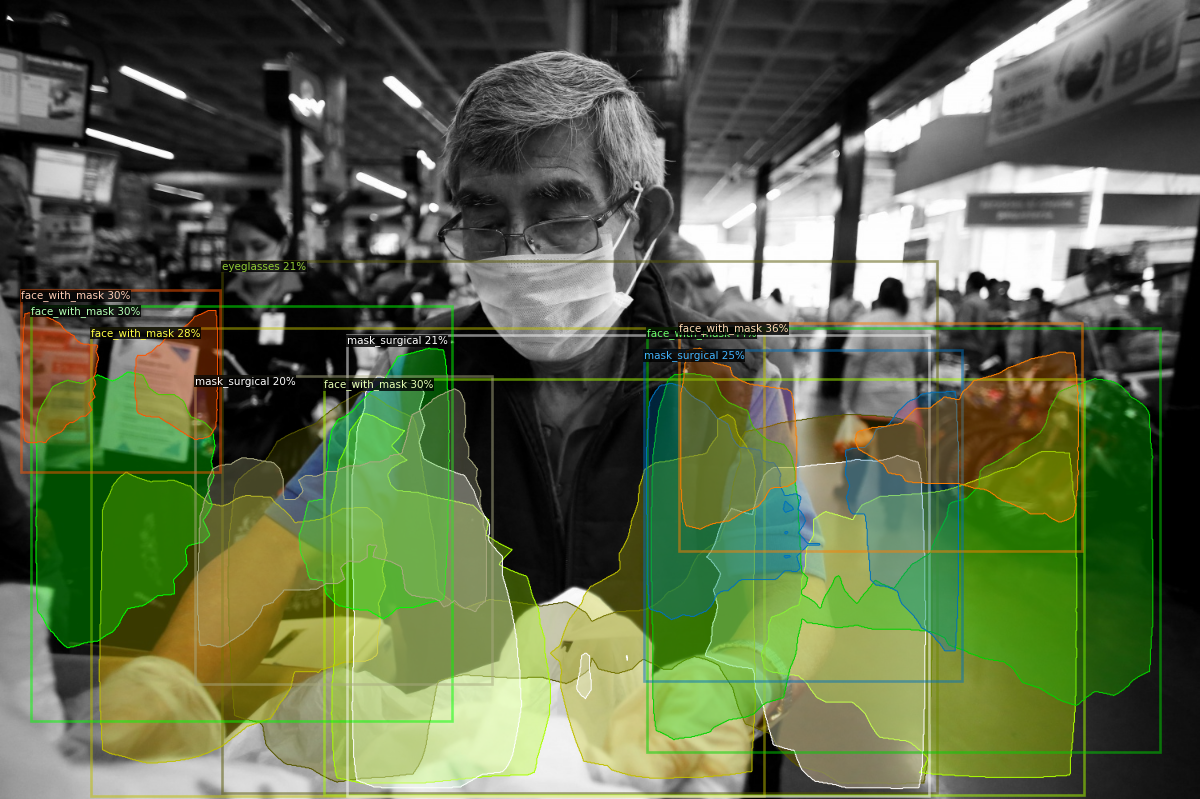

{'instances': Instances(num_instances=1, image_height=416, image_width=740, fields=[pred_boxes: Boxes(tensor([[ 23.5694, 279.5511, 305.5530, 414.7485]], device='cuda:0')), scores: tensor([0.2950], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}


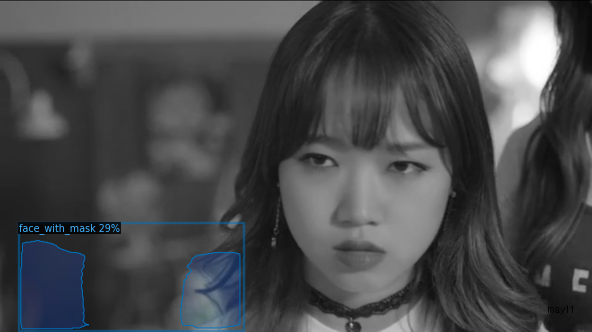

{'instances': Instances(num_instances=4, image_height=609, image_width=1080, fields=[pred_boxes: Boxes(tensor([[ 83.4197, 293.8254, 534.2216, 594.9688],
        [183.0066, 303.7678, 602.7227, 602.6345],
        [582.6967, 303.2397, 995.1124, 605.5181],
        [182.0733, 315.6536, 606.2780, 602.9751]], device='cuda:0')), scores: tensor([0.3108, 0.2941, 0.2909, 0.2529], device='cuda:0'), pred_classes: tensor([0, 1, 0, 4], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]

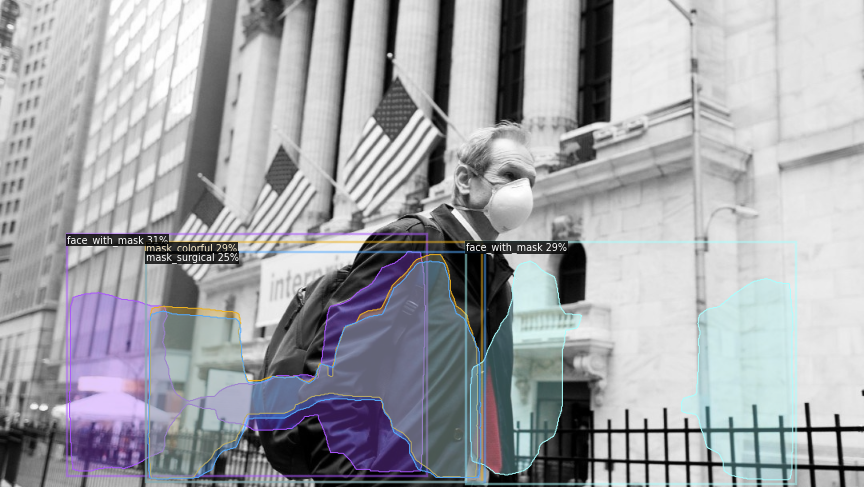

In [50]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(test_dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=text_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])